# Description

The purpose of the notebook is to create a standardized way of analyzing datasets with basic machine learning techniques. 

All imports are done under imports. 

The class DataAnalysis is created below with built-in functions for quick analyzing. 

For more comprehensive data analysis, some of the functions can be copied, though one is best of preparing another notebook with more extensive cleaning, feature engineering, hyperparameter tuning, more models and deeper models.

For classification, a decision tree model, a KNN model and a random forest model is trained.

_________________________________

# IMPORTS

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Data wrangling 
import pandas as pd 
import numpy as np

# Visualization
import pandas
import seaborn as sn
import matplotlib.pyplot as plt 

# Model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# CLASS: DataAnalysis

In [8]:
class DataAnalysis:
    '''
    The DataAnalysis class is used for objectives such as: 'Time Series', 'Classification' and 'Regression.' 
    '''
    def __init__(self, df, y, objective):
        self.df = df
        
         # Define objective 
        self.objective = objective
        print('The objective of the analysis is: ', objective)
        print('------------------------------------------------------------------------------')
        
        # Classification specific
        if self.objective.lower() == 'classification':
            print('-----------------------------------------------------------------------------')
            print('The first 5 rows of the dataframe')
            display(self.df.head())
            
            print('-----------------------------------------------------------------------------')
            print('Distribution of categories\n')
            print(self.df[y].value_counts(normalize=True))
            
            print('-----------------------------------------------------------------------------')
            print('Dataframe info\n')
            print(self.df.info())
            
            print('-----------------------------------------------------------------------------')
            print('Count, mean, standard deviation and five-number summary')
            display(self.df.describe())
            
            print('-----------------------------------------------------------------------------')
            print('Correlation matrix')
            plt.figure(figsize=(12,10))
            ax = sn.heatmap(self.df.corr(), annot=True, linewidth=0.5)
            ax.set_xlim([11,0])
            ax.set_ylim([0,11])
            plt.show()
            
            print('-----------------------------------------------------------------------------')

            # X and y
            self.X = self.df.drop(y, axis = 1)
            self.y = self.df[y]
    
    def train_test_split(self, test_size):
        # Train-test split
        # Initialize object
        sss = StratifiedShuffleSplit(n_splits=1, test_size = test_size)

        # Create indexes 
        train_index, test_index = next(sss.split(self.X, self.y))

        # Assign set
        self.X_train, self.X_test = self.X.loc[train_index], self.X.loc[test_index]
        self.y_train, self.y_test = self.y.loc[train_index], self.y.loc[test_index]
        
        # KNN needs scaled data
        # Scaling 
        ss = StandardScaler()
        self.X_train_ss = ss.fit_transform(self.X_train)
        self.X_test_ss = ss.fit_transform(self.X_test)

        
    def find_k_for_knn(self):
        
        # Setting up parameters for hyperparameter search
        max_k = 40
        f1_scores = list()
        error_rates = list()

        # Looping to find best k
        for k in range(1, max_k):

            # KNN
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
            knn = knn.fit(self.X_train_ss, self.y_train)

            #METRICS 
            y_pred = knn.predict(self.X_test_ss)

            #ERROR
            error = 1-round(accuracy_score(self.y_test, y_pred), 4)
            error_rates.append((k, error))

        # Making dataframe  
        error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])
        
        # Plotting the elbow curve
        plt.figure(dpi=300)
        ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
        ax.set(xlabel='K', ylabel='Error Rate')
        ax.set_xticks(range(1, max_k, 2))
        plt.title('KNN Elbow Curve')
        plt.show()
        #plt.savefig('knn_elbow.png')
        
    def find_trees_for_randomforest(self):
        # Initialize classifier
        RF = RandomForestClassifier(oob_score = True, warm_start = True, n_jobs = -1)

        # Find lowest out-of-bag error 
        oob = list()
        for n_trees in range(20, 200, 20):
            RF.set_params(n_estimators = n_trees)
            RF.fit(self.X_train, self.y_train)

            # OOB error and appending it
            oob_error = 1- RF.oob_score_ 
            oob.append(pd.Series({'# of trees': n_trees, 'OOB error': oob_error}))
            
        oob_frame = pd.concat(oob, axis=1).T.set_index('# of trees')
        plt.bar(oob_frame.index, oob_frame['OOB error'])
        plt.xlabel('# of trees')
        plt.ylabel('OOB error')
        
        opt_trees_error = oob_frame.min()
        self.opt_trees = oob_frame.idxmin()[0]
        print(f'The lowest out-of-bag error was with {self.opt_trees} trees and the error was {opt_trees_error}')
    

        
    def create_predict_performance(self, k_for_knn):
        # CLASSIFIERS------------------------------------------------------------

        # Decision tree, GridSearchCV--------------------------------------------
        dt = DecisionTreeClassifier()
        # Fit the classifier 
        dt = dt.fit(self.X_train, self.y_train)
        
        
        #Define params to try
        param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
                      'max_features': range(1, len(dt.feature_importances_)+1)}

        # Create instance
        GR = GridSearchCV(DecisionTreeClassifier(),
                          param_grid=param_grid,
                          scoring = 'accuracy',
                          n_jobs = -1)

        # Fit object
        self.GR = GR.fit(self.X_train, self.y_train)

        #Predictions
        self.y_pred_GR = self.GR.predict(self.X_test)



        # K-Neighbors classifier--------------------------------------------------

        # KNN
        knn_ss = KNeighborsClassifier(n_neighbors=k_for_knn)
        self.knn_ss = knn_ss.fit(self.X_train_ss, self.y_train)
        self.y_pred_knn_ss = self.knn_ss.predict(self.X_test_ss)



        # RandomForest, ensemble model-----------------------------------------------
        # Initialize classifier
        RF = RandomForestClassifier(oob_score = True, warm_start = True, n_jobs = -1, n_estimators=int(self.opt_trees))
        self.RF = RF.fit(self.X_train, self.y_train)
        self.y_pred_RF = self.RF.predict(self.X_test)
        
        
        
        # Show performance 
        print('Gridsearch CV Decision Trees')
        print(classification_report(self.y_test, self.y_pred_GR))
        print('--------------------------------------------------------')
        print('Scaled KNN')
        print(classification_report(self.y_test, self.y_pred_knn_ss))
        print('--------------------------------------------------------')
        print('Random Forest')
        print(classification_report(self.y_test, self.y_pred_RF))
        
        
    def show_manual_roc_curve(self):
        # No skill prediction (majority class)
        ns_probs = [0 for _ in range(len(self.y_test))]

        # Probabilities 
        dt_probs = self.GR.predict_proba(self.X_test)
        knn_probs = self.knn_ss.predict_proba(self.X_test_ss)
        RF_probs = self.RF.predict_proba(self.X_test)

        # Only keep only probability for positive outcomes
        dt_probs = dt_probs[:, 1]
        knn_probs = knn_probs[:, 1]
        RF_probs = RF_probs[:, 1]

        # Calcuate scores 
        ns_auc = roc_auc_score(self.y_test, ns_probs)
        dt_auc = roc_auc_score(self.y_test, dt_probs)
        knn_auc = roc_auc_score(self.y_test, knn_probs)
        RF_auc = roc_auc_score(self.y_test, RF_probs)

        # Scores
        print('No Skill: ROC AUC=%.3f' % (ns_auc))
        print('Decision Tree: ROC AUC=%.3f' % (dt_auc))
        print('KNN: ROC AUC=%.3f' % (knn_auc))
        print('Random Forest: ROC AUC=%.3f' % (RF_auc))

        # ROC curves
        ns_fpr, ns_tpr, _ = roc_curve(self.y_test, ns_probs)
        dt_fpr, dt_tpr, _ = roc_curve(self.y_test, dt_probs)
        knn_fpr, knn_tpr, _ = roc_curve(self.y_test, knn_probs)
        RF_fpr, RF_tpr, _ = roc_curve(self.y_test, RF_probs)

        # Plot ROC curves
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
        plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
        plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest')

        # Axis, legend and plot
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show();

# 1. DATA, EDA, SETTING PARAMETERS AND INITIALIZING CLASS

In [9]:
# Import dataset 
index_name_list = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'Particle']
df = pd.read_csv('data/magic04.data', header = None, names = index_name_list)

# Change particles to binary (G = Gamma = 1, H = Hadron = 0)
df['Particle'] = df['Particle'].replace('h', 0).replace('g',1)

The objective of the analysis is:  Classification
------------------------------------------------------------------------------
-----------------------------------------------------------------------------
The first 5 rows of the dataframe


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Particle
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


-----------------------------------------------------------------------------
Distribution of categories

1    0.64837
0    0.35163
Name: Particle, dtype: float64
-----------------------------------------------------------------------------
Dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  Particle  19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB
None
-----------------------------------------------------------------------

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Particle
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026,0.648370
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787,0.477492
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600,0.000000
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250,0.000000
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450,1.000000
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825,1.000000
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000,1.000000


-----------------------------------------------------------------------------
Correlation matrix
This may take a couple of seconds...


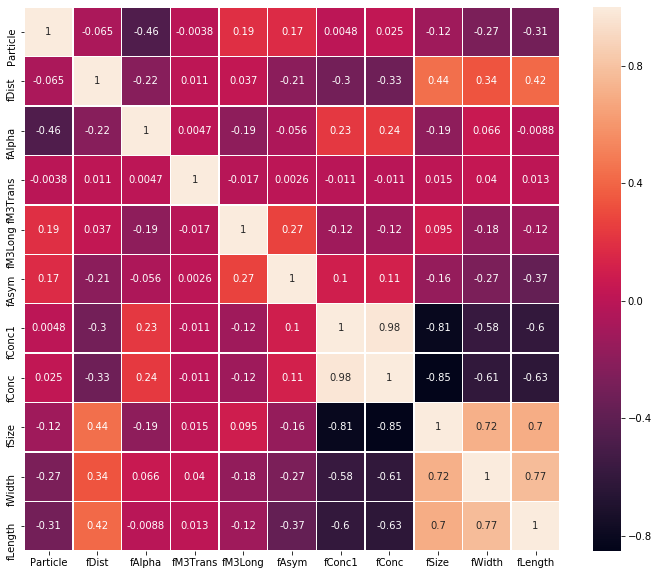

-----------------------------------------------------------------------------


In [10]:
model = DataAnalysis(df, 'Particle', 'Classification')

# 2. DATA ENGINEERING

In [11]:
model.train_test_split(0.3)

# 2.1. Hyperparameter search

<Figure size 1800x1200 with 0 Axes>

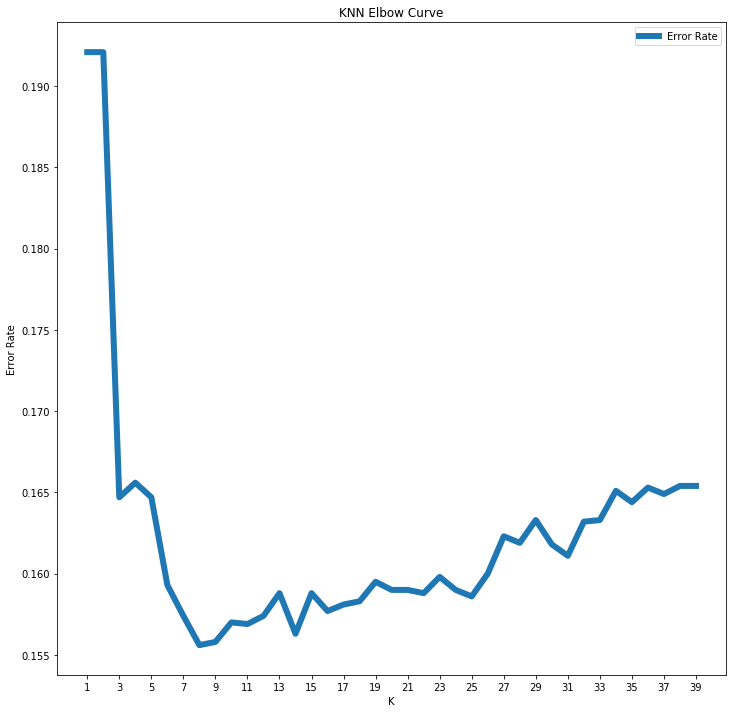

In [12]:
model.find_k_for_knn()

The lowest out-of-bag error was with 140.0 trees and the error was OOB error    0.119498
dtype: float64


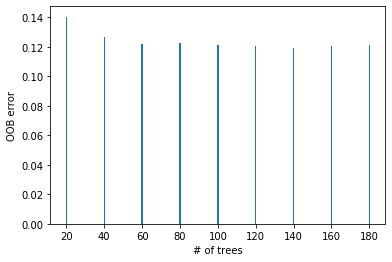

In [13]:
model.find_trees_for_randomforest()

# 3. MODEL

In [14]:
model.create_predict_performance(14) # 14 relates to the K in KNN, and found with .find_k_for_knn() using the elbow method

Gridsearch CV Decision Trees
              precision    recall  f1-score   support

           0       0.81      0.69      0.74      2006
           1       0.84      0.91      0.88      3700

    accuracy                           0.83      5706
   macro avg       0.83      0.80      0.81      5706
weighted avg       0.83      0.83      0.83      5706

--------------------------------------------------------
Scaled KNN
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      2006
           1       0.84      0.94      0.88      3700

    accuracy                           0.84      5706
   macro avg       0.84      0.80      0.81      5706
weighted avg       0.84      0.84      0.83      5706

--------------------------------------------------------
Random Forest
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      2006
           1       0.88      0.93      0.91      3700

    accuracy  

Note: Precision is the ratio of true positives identified out of all positives predicted, where recall is ratio true positives predicted out of all positives

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.877
KNN: ROC AUC=0.885
Random Forest: ROC AUC=0.932


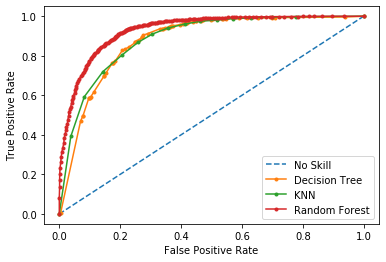

In [252]:
model.show_manual_roc_curve()

__________________________________________

# Post-analysis

### Feature relative importance

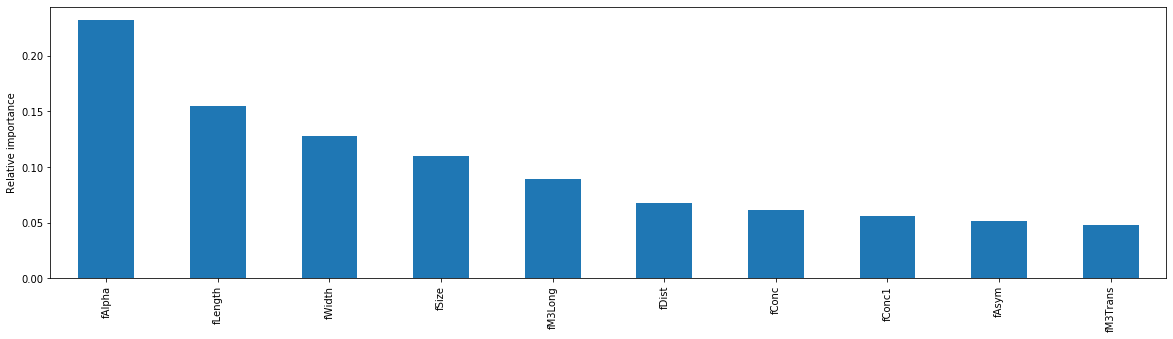

In [15]:
feature_plot = pd.Series(model.RF.feature_importances_, index=model.X.columns).sort_values(ascending=False)

ax = feature_plot.plot(kind='bar', figsize = (20,5))
ax.set(ylabel='Relative importance');